# STAT41130 — RNNs & LSTMs (Fixed): Using a Real Time Series via Siphon/NCSS

This version fixes the single-observation issue in Example 2 by retrieving a true time series from the **GFS (0.5°) Best** dataset using Siphon’s **NCSS**. Examples 4 and 6 also use this source.

In [ ]:
# If needed, install dependencies (uncomment in a fresh environment)
# %pip install torch --quiet
# %pip install metpy siphon xarray netCDF4 numpy pandas matplotlib scikit-learn --quiet

Note: you may need to restart the kernel to use updated packages.


In [1]:
import numpy as np
import pandas as pd
import torch, torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from datetime import datetime, timedelta, timezone
import warnings

warnings.filterwarnings("ignore")
torch.manual_seed(0); np.random.seed(0)
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DEVICE

'cuda'

In [2]:
def make_sequences(array_like, seq_len, target_horizon=1, target_cols=None):
    data = np.asarray(array_like)
    T, F = data.shape
    if target_cols is None: target_cols = [0]
    X, y = [], []
    for t in range(T - seq_len - target_horizon + 1):
        X.append(data[t:t+seq_len, :])
        y.append(data[t+seq_len+target_horizon-1, target_cols])
    return np.array(X, np.float32), np.array(y, np.float32)

class SeqDataset(Dataset):
    def __init__(self, X, y): self.X=torch.tensor(X); self.y=torch.tensor(y)
    def __len__(self): return self.X.shape[0]
    def __getitem__(self, i): return self.X[i].float(), self.y[i].float()

def train_epoch(model, loader, criterion, optimizer):
    model.train(); total=0.0
    for Xb, yb in loader:
        Xb, yb = Xb.to(DEVICE), yb.to(DEVICE)
        optimizer.zero_grad(); out = model(Xb)
        loss = criterion(out, yb); loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step(); total += loss.item()*Xb.size(0)
    return total/len(loader.dataset)

@torch.no_grad()
def eval_epoch(model, loader, criterion):
    model.eval(); total=0.0
    for Xb, yb in loader:
        Xb, yb = Xb.to(DEVICE), yb.to(DEVICE)
        out = model(Xb); loss = criterion(out, yb)
        total += loss.item()*Xb.size(0)
    return total/len(loader.dataset)

@torch.no_grad()
def predict(model, X):
    X = torch.tensor(X, dtype=torch.float32, device=DEVICE)
    return model.eval()(X).cpu().numpy()

def plot_series(true_series, pred_series=None, title=""):
    plt.figure(figsize=(8,3)); plt.plot(true_series, label="true")
    if pred_series is not None: plt.plot(pred_series, label="pred")
    plt.title(title); plt.legend(); plt.show()

## 1) Toy RNN on synthetic data

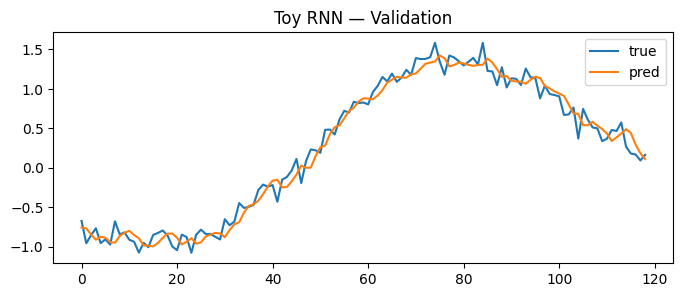

In [3]:
T = 500; t = np.arange(T)
series = np.sin(0.03*t) + 0.5*np.sin(0.07*t+1.2) + 0.1*np.random.randn(T)
data = series.reshape(-1,1); seq_len=24
X, y = make_sequences(data, seq_len, 1, [0])
X_tr, X_val, y_tr, y_val = train_test_split(X, y, test_size=0.25, shuffle=False)

train_ds = SeqDataset(X_tr, y_tr); val_ds = SeqDataset(X_val, y_val)
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=64)

class SimpleRNN(nn.Module):
    def __init__(self, input_size, hidden, out):
        super().__init__(); self.rnn=nn.RNN(input_size, hidden, batch_first=True); self.fc=nn.Linear(hidden,out)
    def forward(self,x): out,_=self.rnn(x); return self.fc(out[:,-1,:])

rnn_toy = SimpleRNN(1,32,1).to(DEVICE); crit=nn.MSELoss(); opt=torch.optim.Adam(rnn_toy.parameters(),1e-2)
for _ in range(25):
    train_epoch(rnn_toy, train_loader, crit, opt); _=eval_epoch(rnn_toy, val_loader, crit)
y_pred_toy = predict(rnn_toy, X_val); plot_series(y_val.squeeze(), y_pred_toy.squeeze(), "Toy RNN — Validation")

## 2) Fixed: Real-world RNN — GFS (0.5°) time series via Siphon/NCSS

In [4]:
from siphon.catalog import TDSCatalog
from netCDF4 import num2date

def fetch_gfs_timeseries(lat, lon, var='Temperature_isobaric', level_pa=100000, days=7):
    cat = TDSCatalog('http://thredds.ucar.edu/thredds/catalog/grib/NCEP/GFS/Global_0p5deg/catalog.xml?dataset=grib/NCEP/GFS/Global_0p5deg/Best')
    ds = list(cat.datasets.values())[0] if isinstance(cat.datasets, dict) else cat.datasets[0]
    ncss = ds.subset()
    q = ncss.query(); now = datetime.now(timezone.utc)
    q.lonlat_point(lon, lat).vertical_level(level_pa).time_range(now, now + timedelta(days=days))
    q.variables(var).accept('netcdf'); resp = ncss.get_data(q)
    arr = resp.variables[var][:].squeeze()
    tvar = resp.variables['time']; times = num2date(tvar[:].squeeze(), tvar.units, only_use_cftime_datetimes=False)
    return np.array(times), np.array(arr, np.float32)

lat, lon = 53.35, -6.26  # Dublin
times_w, temp_w = fetch_gfs_timeseries(lat, lon, 'Temperature_isobaric', 100000, days=7)
data_w = temp_w.reshape(-1,1); seq_len=12
Xw, yw = make_sequences(data_w, seq_len, 1, [0])
Xw_tr, Xw_val, yw_tr, yw_val = train_test_split(Xw, yw, test_size=0.25, shuffle=False)

scaler = StandardScaler().fit(Xw_tr.reshape(-1, Xw_tr.shape[-1]))
Xw_tr_sc = scaler.transform(Xw_tr.reshape(-1,1)).reshape(Xw_tr.shape)
Xw_val_sc = scaler.transform(Xw_val.reshape(-1,1)).reshape(Xw_val.shape)

train_w = DataLoader(SeqDataset(Xw_tr_sc, yw_tr), batch_size=64, shuffle=True)
val_w   = DataLoader(SeqDataset(Xw_val_sc, yw_val), batch_size=64)

rnn_w = SimpleRNN(1,32,1).to(DEVICE); opt_w = torch.optim.Adam(rnn_w.parameters(), 5e-3); crit_w = nn.MSELoss()
for _ in range(20):
    train_epoch(rnn_w, train_w, crit_w, opt_w); _=eval_epoch(rnn_w, val_w, crit_w)

y_pred_w = predict(rnn_w, Xw_val_sc); plot_series(yw_val.squeeze(), y_pred_w.squeeze(), "RNN on GFS Temperature — Validation")

ModuleNotFoundError: No module named 'siphon'

## 3) Toy LSTM

In [ ]:
class SimpleLSTM(nn.Module):
    def __init__(self, input_size, hidden, out):
        super().__init__(); self.lstm=nn.LSTM(input_size, hidden, batch_first=True); self.fc=nn.Linear(hidden,out)
    def forward(self,x): out,_=self.lstm(x); return self.fc(out[:,-1,:])

lstm_toy = SimpleLSTM(1,32,1).to(DEVICE); opt_l=torch.optim.Adam(lstm_toy.parameters(),1e-2); crit=nn.MSELoss()
for _ in range(25):
    train_epoch(lstm_toy, train_loader, crit, opt_l); _=eval_epoch(lstm_toy, val_loader, crit)
y_pred_tl = predict(lstm_toy, X_val); plot_series(y_val.squeeze(), y_pred_tl.squeeze(), "Toy LSTM — Validation")

## 4) Real-world LSTM — same GFS time series

In [ ]:
lstm_w = SimpleLSTM(1,32,1).to(DEVICE); opt_wl=torch.optim.Adam(lstm_w.parameters(),5e-3); crit_w=nn.MSELoss()
for _ in range(20):
    train_epoch(lstm_w, train_w, crit_w, opt_wl); _=eval_epoch(lstm_w, val_w, crit_w)
y_pred_wl = predict(lstm_w, Xw_val_sc); plot_series(yw_val.squeeze(), y_pred_wl.squeeze(), "LSTM on GFS Temperature — Validation")

## 5) RNN vs LSTM — comparison

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,3))
plt.plot(yw_val.squeeze(), label="true"); plt.plot(y_pred_w.squeeze(), label="RNN pred"); plt.plot(y_pred_wl.squeeze(), label="LSTM pred")
plt.title("GFS Temperature — RNN vs LSTM on Validation"); plt.legend(); plt.show()

## 6) Multi-output LSTM — two pressure levels (1000 & 850 hPa)

In [ ]:
_, t1000 = fetch_gfs_timeseries(lat, lon, 'Temperature_isobaric', 100000, 7)
_, t850  = fetch_gfs_timeseries(lat, lon, 'Temperature_isobaric',  85000, 7)
Tmin = min(len(t1000), len(t850))
multi = np.stack([t1000[:Tmin], t850[:Tmin]], axis=1)
Xm, ym = make_sequences(multi, seq_len=12, target_horizon=1, target_cols=[0,1])

Xm_tr, Xm_val, ym_tr, ym_val = train_test_split(Xm, ym, test_size=0.25, shuffle=False)
scaler_m = StandardScaler().fit(Xm_tr.reshape(-1, Xm_tr.shape[-1]))
Xm_tr_sc = scaler_m.transform(Xm_tr.reshape(-1, Xm_tr.shape[-1])).reshape(Xm_tr.shape)
Xm_val_sc = scaler_m.transform(Xm_val.reshape(-1, Xm_val.shape[-1])).reshape(Xm_val.shape)

train_m = DataLoader(SeqDataset(Xm_tr_sc, ym_tr), batch_size=64, shuffle=True)
val_m   = DataLoader(SeqDataset(Xm_val_sc, ym_val), batch_size=64)

lstm_m = SimpleLSTM(Xm_tr_sc.shape[2], 48, 2).to(DEVICE); opt_m = torch.optim.Adam(lstm_m.parameters(), 5e-3); crit_m = nn.MSELoss()
for _ in range(25):
    train_epoch(lstm_m, train_m, crit_m, opt_m); _=eval_epoch(lstm_m, val_m, crit_m)

y_pred_m = predict(lstm_m, Xm_val_sc)
import matplotlib.pyplot as plt
plt.figure(figsize=(8,3)); plt.plot(ym_val[:,0], label="true T(1000 hPa)"); plt.plot(y_pred_m[:,0], label="pred T(1000 hPa)"); plt.legend(); plt.show()
plt.figure(figsize=(8,3)); plt.plot(ym_val[:,1], label="true T(850 hPa)"); plt.plot(y_pred_m[:,1], label="pred T(850 hPa)"); plt.legend(); plt.show()